# Defense : Distilled Neural Network

First strategy(distilled model):  see  Papernot, N., McDaniel, P., Wu, X., Jha, S., and Swami, A. Distillation as a defense to adversarial perturbations against deep neural networks. arXiv preprint arXiv:1511.04508, 2016b.
  1. Train a network F on the given training set (X,Y) by setting the temperature of the softmax to T.
  2. Compute the scores (after softmax) given by F(X) again and evaluate the scores at temperature T.
  3. Train another network F'_T using softmax at temperature T on the dataset with soft labels (X,F(X)). We refer the model F'_T as the distilled model.
Use the distilled network F'_T with softmax at temperature 1, which is denoted as F'1 during prediction on test data Xtest(or adversarial examples).
Taken Temperature as 100 for training the NetF and NetF'

The rough idea is that existing fast methods for finding adversarial examples (§II.B) rely on looking at the gradient and either adjusting all pixels by a small amount (Goodfellow 2015) or adjusting a small number of salient pixels a large amount (Papernot 2015a). This is most effective when the gradient is large. There are theoretical reasons to expect that distilling a network (more on what this is in a minute) will tend to reduce gradients, encouraging the output to be nearly flat close to training examples. The authors tested this against MNIST and CIFAR10 classifiers, showing strong reductions in the susceptibility to adversarial examples (from 95.89% to 0.45% and 87.89% to 5.11%, respectively), very little loss in accuracy, and increased robustness.
What’s this distillation thing? Originally intended to compress models to run on cheaper hardware, distillation (§II.C) involves a typically smaller network learning another network’s output function. But instead of predicting hard class labels (0 or 1), the distillation network instead predicts the class probabilities generated by the first network. The full probability distribution contains more information than a single label, so intuitively we should be able to take advantage of this. The authors give this example from MNIST: a training example that has high probability for both the 1 and 7 labels “indicates that 7s and 1s look similar and intuitively allows a model to learn the structural similarity between the two digits.” (Emphasis in original.) In this paper rather than compressing the distillation into a smaller network, they train a distillation network of the same size as the original.
There’s a further detail to distillation, which is that — during training — the softmax layer includes a temperature parameter T:

Here the z are the activations of the last layer before the softmax. T = 1 is equivalent to standard softmax. Increasing T has the effect of pushing the resulting probability distribution closer to uniform. At test time the temperature is set back to 1. There’s an argument in §IV.B that higher temperatures also tend to flatten out the Jacobian, which is the real motivation behind this approach. The authors used T = 20.
There are two other main lines of discussion in the paper. One is on a robustness metric (§III.A) for neural nets building on Fawzi 2015, defining the metric as the expected minimum distance to an adversarial example (the expectation is over points drawn from the distribution being modeled). Defensive distillation improved robustness by 7.9x and 5.6x for the networks tested, according to this metric.m

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from Net import NetF , NetF1, Net
from attack import test_fgsm_mnist,test_fgsm_mnist_distilled, test_LBFGS_mnist, test_vanilla_mnist, target_adversarial
from defense import validation , fit_distilled

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [201]:
mnist_testset = datasets.MNIST('./data_mnist', 
                   train=False,
                   download=False, 
                   transform=transforms.Compose([transforms.ToTensor()]))

test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=32,shuffle=True)

train_set, val_set = torch.utils.data.random_split(test_loader.dataset,[9900,100])

train_loader = torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)

In [4]:
# Use Cudaz if available + set use_cuda =True
use_cuda= True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  False


### Load teacher

In [5]:
pretrained_teacher = "weights/teacher_model_weights_T_100"

In [6]:
# Init teacher Network
teacher_model = NetF().to(device)

# Load pretrained model
teacher_model.load_state_dict(torch.load(pretrained_teacher, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
teacher_model.eval() # 92% acc on val set

NetF(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### Distilled NN  data

In [16]:
distilled_model= NetF1().to(device)

optimizer = optim.Adam(distilled_model.parameters(), lr=0.001, betas=(0.9, 0.999))

loss_distilled = fit_distilled(teacher_model,
                               distilled_model,
                               device, 
                                optimizer, 
                                train_loader,
                                val_loader,
                                epochs=20,
                                T=100)

Fitting the distilled model



Epoch: 1 Loss: 1.9089695469025643 



Epoch: 1 Accuracy: 0.61 



Epoch: 2 Loss: 0.5838131705599446 



Epoch: 2 Accuracy: 0.76 



Epoch: 3 Loss: 0.4584233807940637 



Epoch: 3 Accuracy: 0.76 



Epoch: 4 Loss: 0.44284805838138824 



Epoch: 4 Accuracy: 0.77 



Epoch: 5 Loss: 0.4381538068094561 



Epoch: 5 Accuracy: 0.78 



Epoch: 6 Loss: 0.43659649395173594 



Epoch: 6 Accuracy: 0.78 



Epoch: 7 Loss: 0.4353901876076575 



Epoch: 7 Accuracy: 0.8 



Epoch: 8 Loss: 0.43462290811923243 



Epoch: 8 Accuracy: 0.79 



Epoch: 9 Loss: 0.43391573054175225 



Epoch: 9 Accuracy: 0.79 



Epoch: 10 Loss: 0.434226812326139 



Epoch: 10 Accuracy: 0.79 



Epoch: 11 Loss: 0.4342641795354505 



Epoch: 11 Accuracy: 0.8 



Epoch: 12 Loss: 0.43363744578053876 



Epoch: 12 Accuracy: 0.8 



Epoch: 13 Loss: 0.43294142374107913 



Epoch: 13 Accuracy: 0.8 



Epoch: 14 Loss: 0.43339959767556957 



Epoch: 14 Accuracy: 0.79 



Epoch: 15 Loss: 0.432941216518802 



Epoch: 15 Accuracy: 0.78 



Epoch: 16 Loss: 0.43314727044874624 



Epoch: 16 Accuracy: 0.78 



Epoch: 17 Loss: 0.43227155410474344 



Epoch: 17 Accuracy: 0.79 



Epoch: 18 Loss: 0.4327602220158423 



Epoch: 18 Accuracy: 0.8 



Epoch: 19 Loss: 0.43221254512186974 



Epoch: 19 Accuracy: 0.8 



Epoch: 20 Loss: 0.4322517694484803 



Epoch: 20 Accuracy: 0.79 


### Why use temperature ? 

This is a strategy where we train the model to output probabilities of different classes, rather than hard decisions about which class to output. The probabilities are supplied by an earlier model, trained on the same task using hard class labels.

* Model distillation is a technique that learns a secondary model to mimic what a primary model has learned, by training on the primary model’s “soft” probability outputs, rather than the “hard” (0/1) true label.
* the secondary model is trained in a way that pushes it to produce a more even distribution over outputs, rather than one very confident value and many other vary small ones.

In [34]:
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)

In [35]:
data ,target = next(iter(val_loader))
data = data.to(device)
target = target.to(device)

In [66]:
norms =[]
losses =[]
for T in np.linspace(1,100,10):
    data.requires_grad = True
    output = teacher_model(data)
    probas = F.softmax(output/T, dim=1)    
    output = F.log_softmax(output/T, dim=1)    
    loss = F.nll_loss(output, target)
    losses.append(loss)
    teacher_model.zero_grad()
    # Backward pass
    loss.backward()
    data_grad = data.grad.data
    #print('T =', T,torch.norm(data_grad))
    norms.append(torch.norm(data_grad))
    data.grad = None
    

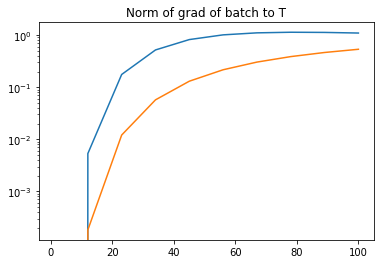

In [67]:
plt.yscale('log')
plt.plot(np.linspace(1,100,10),norms)
plt.plot(np.linspace(1,100,10),losses)

plt.title('Norm of grad of batch to T')
plt.show()

## Defense againt Vanilla gradient attack

In [ ]:
# Init the network
pretrained_model = "weights/lenet_mnist_model.pth"
model = Net().to(device)

#Load pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

accuracies_vanilla_model = []
examples_vanilla_model = []
lmds =[0.01,0.1, 0.5,1]

# Run test for each lambda
for lmd in reversed(lmds):
    final_acc, adv_examples = test_vanilla_mnist(teacher_model,
                                             device,
                                             val_loader, 
                                                mode ='nolog',
                                             lmd=lmd,
                                                T=1)
    accuracies_vanilla_model.append(final_acc)
    examples_vanilla_model.append(adv_examples)

--- 

In [174]:
accuracies_vanilla_distilled = []
examples_vanilla_distilled = []
lmds =[0.01,0.1, 0.5,1]

# Run test for each lambda

for lmd in reversed(lmds):
    final_acc, adv_examples = test_vanilla_mnist(distilled_model,
                                             device,
                                             val_loader, 
                                             lmd=lmd,
                                             mode="nolog", 
                                             T=500)
    accuracies_vanilla_distilled.append(final_acc)
    examples_vanilla_distilled.append(adv_examples)


Lambda 1 Accuracy: 0.82 



Lambda 0.5 Accuracy: 0.82 



Lambda 0.1 Accuracy: 0.73 



Lambda 0.01 Accuracy: 0.05 


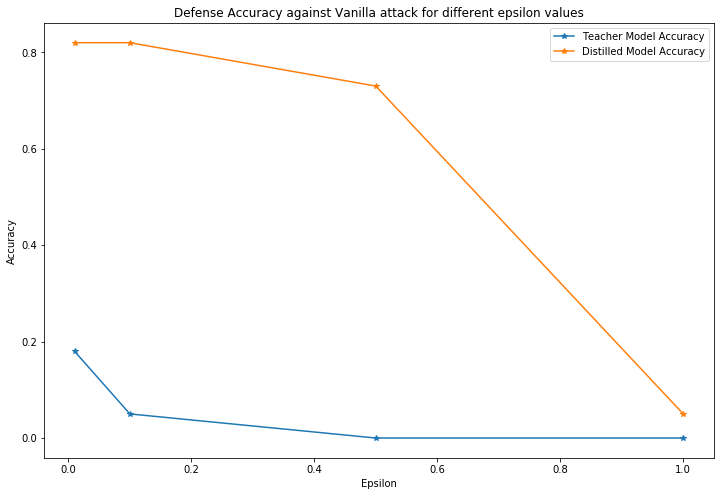

In [175]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(lmds, accuracies_vanilla_model, "*-",label='Teacher Model Accuracy')
ax.plot(lmds, accuracies_vanilla_distilled, "*-",label='Distilled Model Accuracy')
plt.title("Defense Accuracy against Vanilla attack for different epsilon values")
ax.legend()
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

--- 

In [176]:
## Debug 

In [177]:
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)

In [178]:
data ,target = next(iter(val_loader))
data = data.to(device)
target = target.to(device)

In [179]:
label_adv = torch.randint(0,9,size=[target.size(0)]).to(device)
while (label_adv== target).sum().item() > 0:
    label_adv = torch.randint(0,9,size=[target.size(0)]).to(device)

In [180]:
adv = target_adversarial(distilled_model, 
                         data,
                         device,
                         n=label_adv,
                         epochs=100,
                         eta=0.5,
                         lmd=0.7,
                         mode="nolog",
                         T=500)

In [181]:
output = distilled_model(adv)
output = F.softmax(output,dim=1)
final_pred = output.max(1, keepdim=True)[1]

In [ ]:
i = np.random.randint(0,31,size=1)
img = data[i].squeeze().detach().cpu().numpy()
adv_img = adv[i].squeeze().detach().cpu().numpy()

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(img)
ax[0].set_title('label {}'.format(target[i].item()))
ax[1].imshow(adv_img)
ax[1].set_title('label adv {}'.format(final_pred[i].item()))

In [ ]:
img = data.squeeze().detach().cpu().numpy()
adv_img = adv.squeeze().detach().cpu().numpy()

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(img,cmap='gray')
ax[0].set_title('label {}'.format(target.item()))
ax[1].imshow(adv_img,cmap='gray')
ax[1].set_title('label adv {}'.format(final_pred.item()))

In [202]:
T=500
pseudo =  F.softmax(teacher_model(data)/T, dim=1)

<BarContainer object of 10 artists>

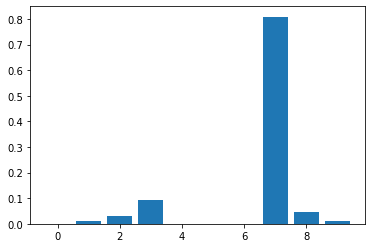

In [203]:
plt.bar(range(10),pseudo.squeeze().detach().cpu().numpy())

In [208]:
out =   F.softmax(distilled_model(data)/T, dim=1)

<BarContainer object of 10 artists>

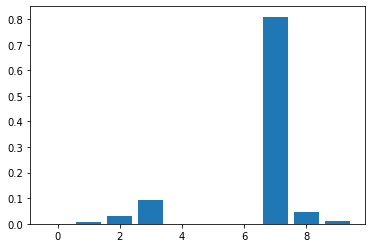

In [209]:
plt.bar(range(10),out.squeeze().detach().cpu().numpy())

--- 

## Defense against FGSM attack

In [ ]:
epsilons = np.linspace(0.01,0.1,num=5)
accuracies_F = []
examples_F = []
probas_F =[]
for eps in epsilons:
    acc, ex, proba_adv = test_fgsm_mnist(teacher_model,
                                         device,
                                         val_loader,
                                         epsilon=eps, 
                                         mode = 'nolog',T=100)
    accuracies_F.append(acc)
    examples_F.append(ex)
    probas_F.append(proba_adv)

In [ ]:
accuracies_distilled = []
examples_distilled = []
probas_distilled =[]
for eps in epsilons:
    acc, ex, proba_adv = test_fgsm_mnist(distilled_model, 
                                         device, 
                                         val_loader, 
                                         eps, 
                                         mode = 'nolog',
                                         T=500)
    accuracies_distilled.append(acc)
    examples_distilled.append(ex)
    probas_distilled.append(proba_adv)

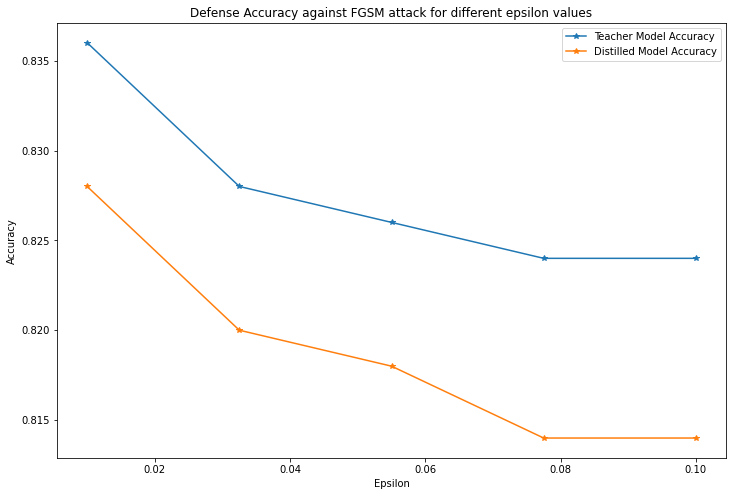

In [109]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(epsilons, accuracies_F, "*-",label='Teacher Model Accuracy')
ax.plot(epsilons, accuracies_distilled, "*-",label='Distilled Model Accuracy')
plt.title("Defense Accuracy against FGSM attack for different epsilon values")
ax.legend()
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
base_model = Net().to(device)
optimizer = optim.Adam(base_model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = F.nll_loss
base_model.train()
print("Fitting the model...")
loss = fit(base_model, 
           device, 
           criterion, 
           optimizer, 
           train_loader, 
           val_loader, 
           T=1, 
           epochs=3, 
           mode='log')

---- 

## Adversarial Training

In [287]:
from defense import adversarial_fit, adversarial_fit_normal

### Using normal FGSM Adversarial training

In [246]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
model.train()

loss = adversarial_fit_normal(model, 
                       device, 
                       optimizer, 
                       train_loader, 
                       val_loader,
                      epochs=10)

Fitting the model with adversarial training...



Epoch :0 Loss: 2.2501397792739097 Acc : 0.13505050505050506



Epoch :1 Loss: 2.04642757581942 Acc : 0.17656565656565656



Epoch :2 Loss: 1.8931444968117608 Acc : 0.20212121212121212



Epoch :3 Loss: 1.786132639610406 Acc : 0.22292929292929292



Epoch :4 Loss: 1.7026400892469618 Acc : 0.24149494949494948



Epoch :5 Loss: 1.6358528252161713 Acc : 0.2586026936026936



Epoch :6 Loss: 1.579719799228905 Acc : 0.2732900432900433



Epoch :7 Loss: 1.532303258249856 Acc : 0.2877777777777778



Epoch :8 Loss: 1.4907630826728513 Acc : 0.3007070707070707



Epoch :9 Loss: 1.4537080298264822 Acc : 0.31157575757575756


In [202]:
accuracies_FGSM = []
examples_FGSM = []
proba_FGSM = []

epsilons =[0.1,0.3,0.5,0.7]
model.eval()
# Run test for each epsilon
for eps in epsilons:
    acc, ex, proba_adv = test_fgsm_mnist(model, 
                                         device, 
                                         test_loader, 
                                         eps,
                                         mode='nolog')
    accuracies_FGSM.append(acc)
    examples_FGSM.append(ex)
    proba_FGSM.append(proba_adv)


Epsilon 0.1 Accuracy: 0.7603 



Epsilon 0.3 Accuracy: 0.4241 



Epsilon 0.5 Accuracy: 0.0702 



Epsilon 0.7 Accuracy: 0.0005 


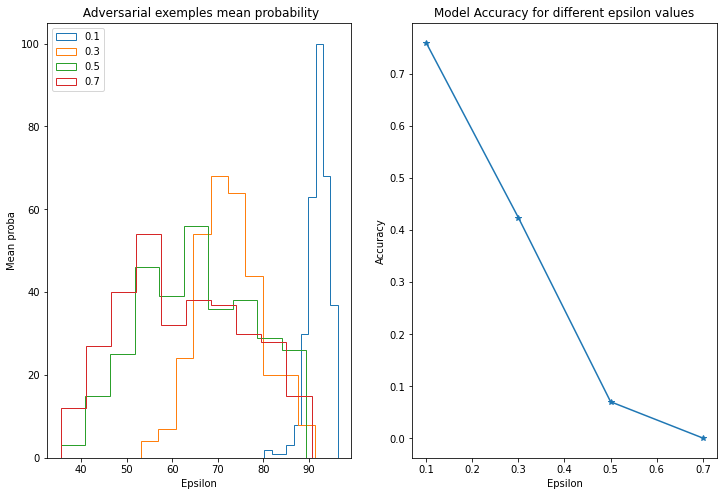

In [238]:
fig, ax = plt.subplots(1,2,figsize=(12,8))
for i, _ in enumerate(epsilons):
    ax[0].hist(proba_FGSM[i],histtype='step', stacked=True, fill=False,label=_)
ax[0].legend()
#ax[0].plot(epsilons, proba_FGSM, "*-")
ax[0].set_title(" Adversarial exemples mean probability")
ax[0].set_xlabel("Epsilon")
ax[0].set_ylabel("Mean proba")


ax[1].plot(epsilons, accuracies_FGSM, "*-")
ax[1].set_title("Model Accuracy for different epsilon values")
ax[1].set_xlabel("Epsilon")
ax[1].set_ylabel("Accuracy")


plt.savefig('Results/Testing FGSM defense mnist.png')
plt.show()

### Using random FGSM Adversarial training

In [292]:

model = Net().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
model.train()

loss = adversarial_fit(model, 
                       device, 
                       optimizer, 
                       train_loader, 
                       val_loader,
                      epochs=10)

Fitting the model with adversarial training...



Epoch :0 Loss: 2.2331100569349345 Acc : 0.0691919191919192



Epoch :1 Loss: 1.9555692237796205 Acc : 0.1095959595959596



Epoch :2 Loss: 1.7734686137530138 Acc : 0.14346801346801347



Epoch :3 Loss: 1.645882064585734 Acc : 0.17431818181818182



Epoch :4 Loss: 1.5492294793273464 Acc : 0.20165656565656565



Epoch :5 Loss: 1.4730778124838164 Acc : 0.22547138047138046



Epoch :6 Loss: 1.4106953679259548 Acc : 0.2465800865800866



Epoch :7 Loss: 1.3581977820516837 Acc : 0.2652146464646465



Epoch :8 Loss: 1.3129895775406448 Acc : 0.2815263748597082



Epoch :9 Loss: 1.2733548607826233 Acc : 0.29625252525252527


In [295]:
accuracies_FGSM = []
examples_FGSM = []
proba_FGSM = []

epsilons =[0.1,0.3,0.5,0.7]
model.eval()
# Run test for each epsilon
for eps in epsilons:
    acc, ex, proba_adv = test_fgsm_mnist(model, 
                                         device, 
                                         test_loader, 
                                         eps,
                                         mode='nolog')
    accuracies_FGSM.append(acc)
    examples_FGSM.append(ex)
    proba_FGSM.append(proba_adv)

TypeError: fgsm_attack() missing 1 required positional argument: 'epsilon'

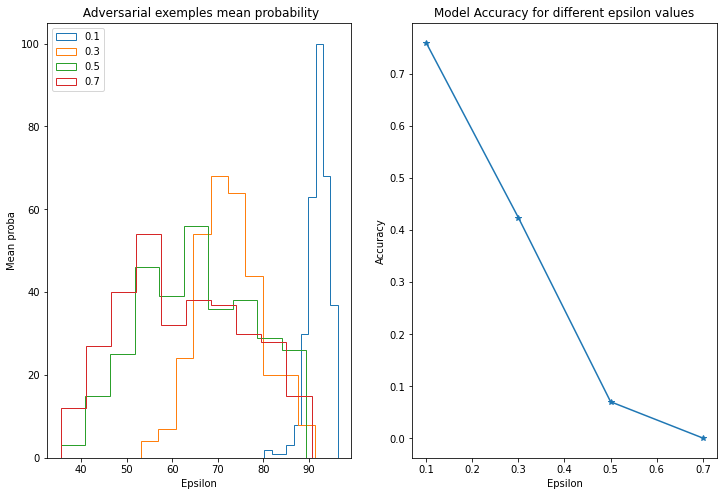

In [294]:
fig, ax = plt.subplots(1,2,figsize=(12,8))
for i, _ in enumerate(epsilons):
    ax[0].hist(proba_FGSM[i],histtype='step', stacked=True, fill=False,label=_)
ax[0].legend()
#ax[0].plot(epsilons, proba_FGSM, "*-")
ax[0].set_title(" Adversarial exemples mean probability")
ax[0].set_xlabel("Epsilon")
ax[0].set_ylabel("Mean proba")


ax[1].plot(epsilons, accuracies_FGSM, "*-")
ax[1].set_title("Model Accuracy for different epsilon values")
ax[1].set_xlabel("Epsilon")
ax[1].set_ylabel("Accuracy")


plt.savefig('Results/Testing FGSM defense mnist.png')
plt.show()

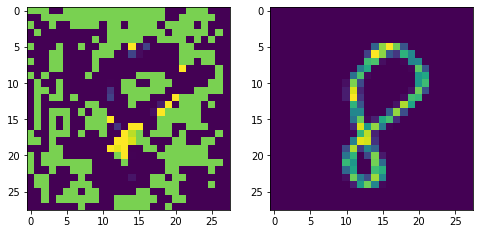

In [240]:
data_n = data[0].squeeze().detach().cpu().numpy()
adv = perturbed_data[0].squeeze().detach().cpu().numpy()
fig, ax = plt.subplots(1,2,figsize=(8,10))
ax[0].imshow(adv)
ax[1].imshow(data_n)

In [281]:
from attack import fgsm_attack, random_fgsm_attack
for data, target in val_loader :
    perturbed_data = random_fgsm_attack(model,device,data,target,epsilon=0.3,alpha=0.33)

4


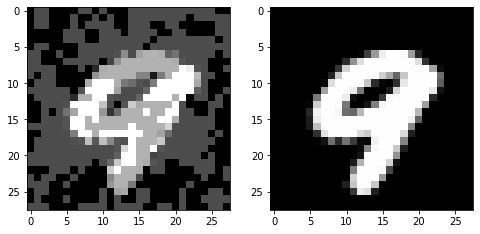

In [284]:
data_n = data.squeeze().detach().cpu().numpy()
adv = perturbed_data.squeeze().detach().cpu().numpy()
fig, ax = plt.subplots(1,2,figsize=(8,10))
ax[0].imshow(adv,cmap='gray')
ax[1].imshow(data_n,cmap='gray')
print(model(perturbed_data).max(1, keepdim=True)[1].item())